# Predicting remaining useful life of an engine

In this experiment we're trying to estimate the remaining useful life (RUL) of an engine (turbine). This notebook follows after the 'RUL prediction of turbine engine (NASA)-ETL' notebook were the raw data was retrieved an a first analysis was performed. In this notebook we will look more at the reteieval of features.

# Features
Now that we loaded and checked the dataset we want to have a better look at the moment of engine failure.<br/>
We can use this also the enhance the dataset with the maximum lifetime of an engine (measured in cycles)

Will there be a clear pattern?

In [1]:
# check if we have the data sets
!ls -l *.h5

-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users   994792 Mar  2 05:18 binary_model.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  2942744 Feb 26 15:04 pd_test_fd001_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  7623224 Feb 26 15:18 pd_test_fd002_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  3726744 Feb 26 15:24 pd_test_fd003_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  9241176 Feb 26 15:36 pd_test_fd004_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users 10385416 Mar  2 09:26 pd_train_enriched_rul_fd001.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users 25359424 Mar  2 09:26 pd_train_enriched_rul_fd002.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users 12233664 Mar  2 09:26 pd_train_enriched_rul_fd003.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users 16495136 Mar  2 09:26 pd_train_enriched_rul_fd004.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  5764072 Feb 26 15:04 pd_train_fd001

In [2]:
# load data set one
from pandas import HDFStore

store = HDFStore('pd_train_fd001_scaled.h5', mode='r')
pd_train_fd001 = store['pd']
store.close()

We're treating the 4 sets as separate sets, we may combine them (later) and see if we could derive at a more generic model. 

**TODO combine the 4 dataset later (or should it be a seperate process?)**<br/>

We will start with dataset 1 and see if we can define a model with enough accuracy. Since we're also on a time constraint we start with subset dataset 1.<br/>

Next step is to determine how long the engine was running before it failed, for each set we need to find the maximum cycle for each engine and run.
I.e. for each engine, cycle combination.


In [3]:
pd_train_fd001.sort_values(by=['unit','cycle'], ascending=True)
pd_train_fd001.head()

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,condition,faultmode,cycleoriginal
0,1,0.00000,0.459770,0.166667,0.0,0.0,0.183730,0.406800,0.309757,0.0,...,0.363989,0.0,0.333333,0.0,0.0,0.713179,0.724662,one,one,1
1,1,0.00277,0.609195,0.250000,0.0,0.0,0.283133,0.453017,0.352634,0.0,...,0.411313,0.0,0.333333,0.0,0.0,0.666667,0.731012,one,one,2
2,1,0.00554,0.252874,0.750000,0.0,0.0,0.343359,0.369522,0.370526,0.0,...,0.357446,0.0,0.166667,0.0,0.0,0.627908,0.621375,one,one,3
3,1,0.00831,0.540230,0.500000,0.0,0.0,0.343359,0.256159,0.331195,0.0,...,0.166605,0.0,0.333333,0.0,0.0,0.573644,0.662385,one,one,4
4,1,0.01108,0.390805,0.333333,0.0,0.0,0.349389,0.257465,0.404625,0.0,...,0.402081,0.0,0.416667,0.0,0.0,0.589149,0.704501,one,one,5


In [4]:
# Assume measurements stopped when engine failed, so the maximum cycle for a particular run is what we need to predict.
# dont use normalised cycle, hard to intepret / model fails.
pd_train_fail_cycle_fd001 = pd_train_fd001.groupby(['unit'], sort=False)['unit','cycleoriginal'].max()
pd_train_fail_cycle_fd001.rename(columns={"cycleoriginal": "max"}, inplace=True)

pd_train_fail_cycle_fd001.head()

,unit,max
unit,,
1,1,192
2,2,287
3,3,179
4,4,189
5,5,269


So how is the failure spread against the engine? <br/>
Can we predict the above found failcycle a reasonable anount of cycles before the failure occors?

Note: what's reasonable? We dont know how many cycles we need to shut down the engine etc.

In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

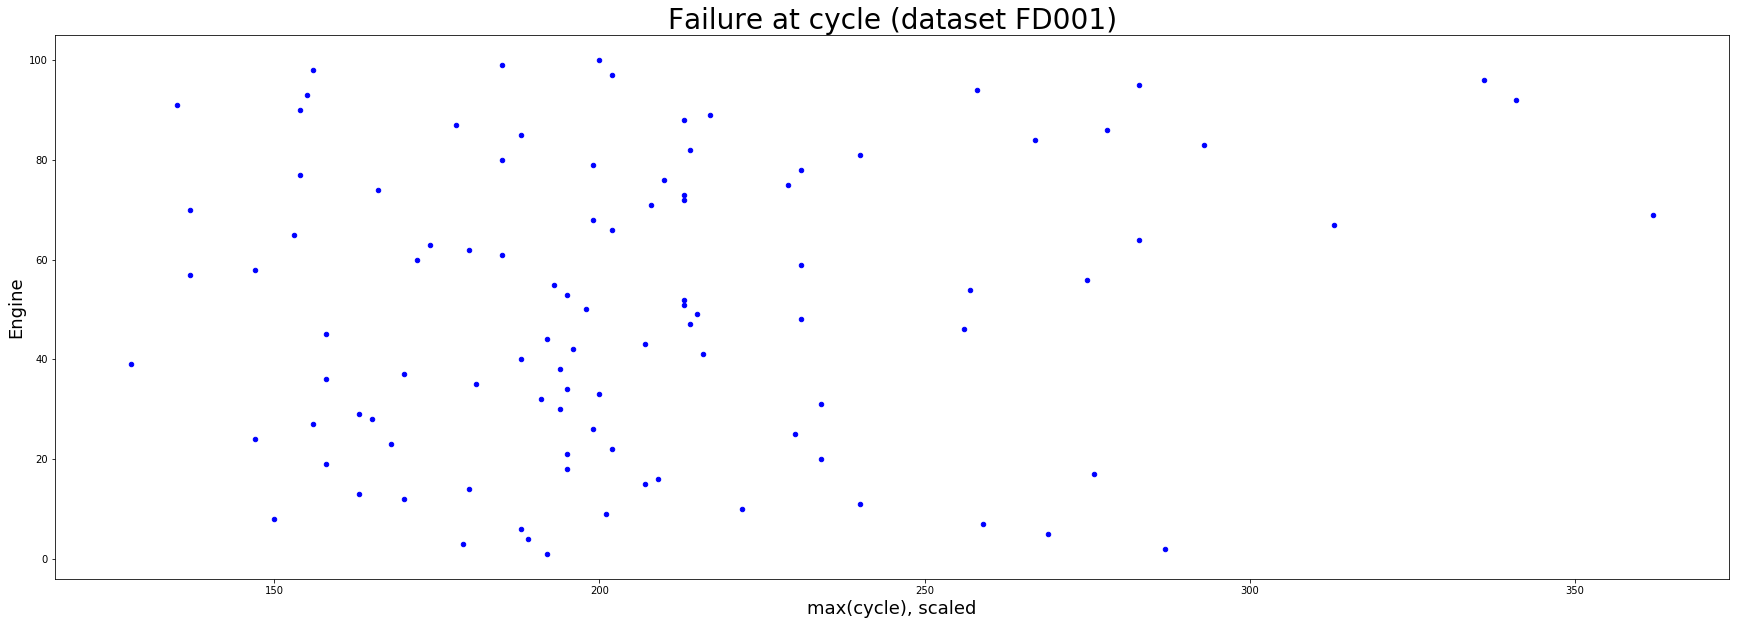

In [6]:
pd_train_fail_cycle_fd001.plot(figsize = (30,10), kind = "scatter", color = "blue", y = "unit", x = "max", legend = False)

plt.ylabel("Engine", fontsize = 18)
plt.xlabel("max(cycle), scaled", fontsize = 18)
plt.title("Failure at cycle (dataset FD001)", fontsize = 28)

plt.show()

Looks like failures are all over the place, hard to see a pattern. One might expect that the higher the cycle the more the engine failures, but it doesn't look like that. Lets check for additional stats.<br/>

What if we have a look at the number of failures over time?

In [7]:
engines = 0

# add total number of failed...
pd_train_fail_cycle_fd001['total_failed'] = 0

# this wont update the dataframe
#for index, row in pd_train_fail_cycle_fd001.sort_values(by=['failcycle']).iterrows():
#    engines += 1
#    row['total_failed'] = engines
#    print(row)
for row in pd_train_fail_cycle_fd001.sort_values(by=['max']).itertuples():
    engines += 1
    pd_train_fail_cycle_fd001.at[row.Index, 'total_failed'] = engines
    
pd_train_fail_cycle_fd001.sort_values(by=['max']).head()

,unit,max,total_failed
unit,,,
39,39,128,1
91,91,135,2
70,70,137,3
57,57,137,4
58,58,147,5


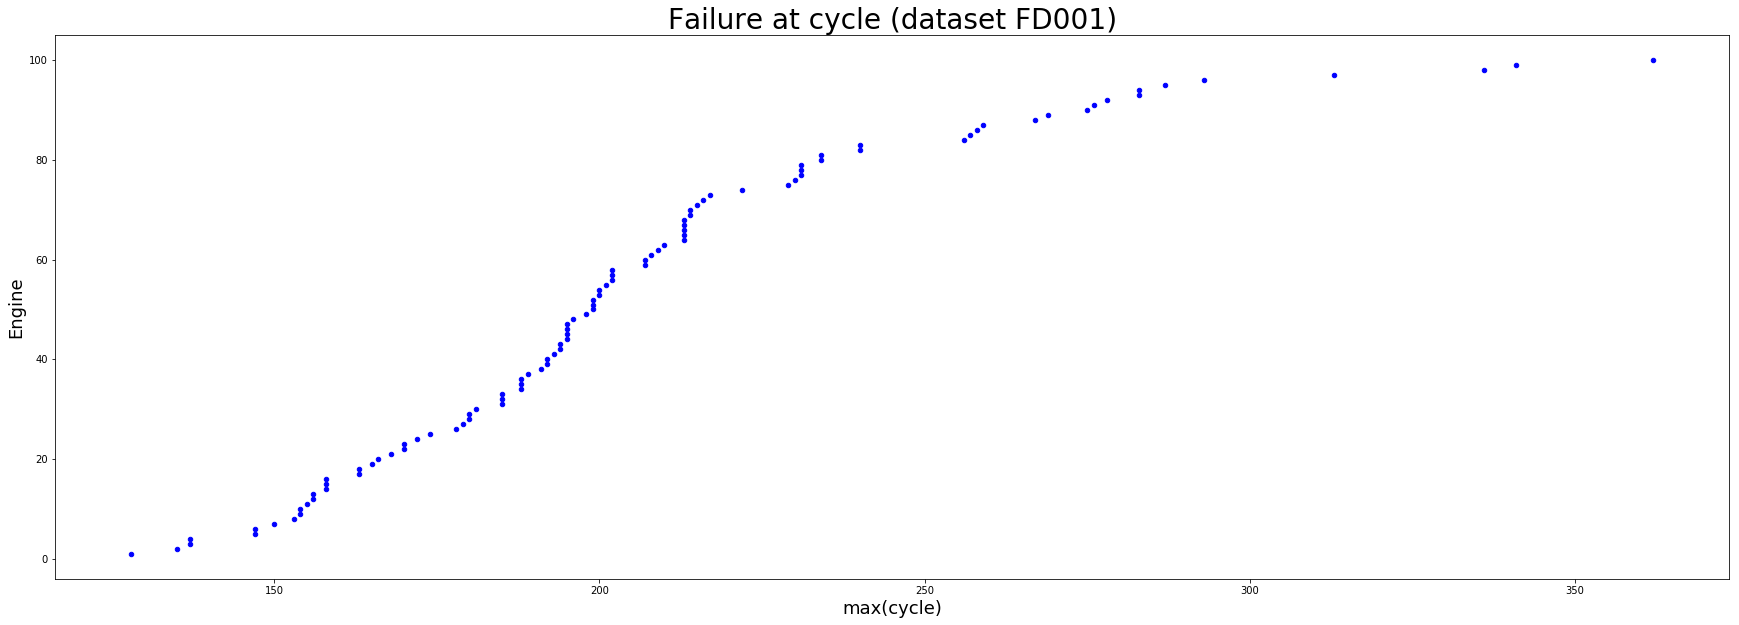

In [8]:
pd_train_fail_cycle_fd001.plot(figsize = (30,10), kind = "scatter", color = "blue", y = "total_failed", x = "max", legend = False)

plt.ylabel("Engine", fontsize = 18)
plt.xlabel("max(cycle)", fontsize = 18)
plt.title("Failure at cycle (dataset FD001)", fontsize = 28)

plt.show()

At least there seems to be somekind of pattern. At a first glance most engine fail between cylce 150 and 300. Sort of curve though betwen 150 and 150 cycles it looks roughly linear.<br/>
So what are the details of the failurecylce?

In [9]:
pd_train_fail_cycle_fd001['max'].describe()

count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: max, dtype: float64

Looking at the stats, on average an engine fails after just 206 cycles, the standard deviation is quite large though, 46 cycles, given the mean of about 206..

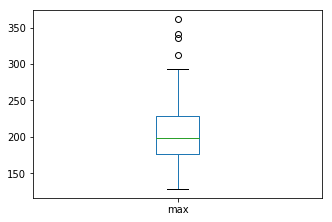

In [10]:
pd_train_fail_cycle_fd001[['max']].plot(figsize = (30,20), kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False)
plt.show()

The box plot only show a few outliers. All in all this gives some confindence that we should be able to predict the moment of failure.<br/>

**Note, we should we remove outliers since they will disrupt the correlation / relation **

Quick peek using an histogram... 

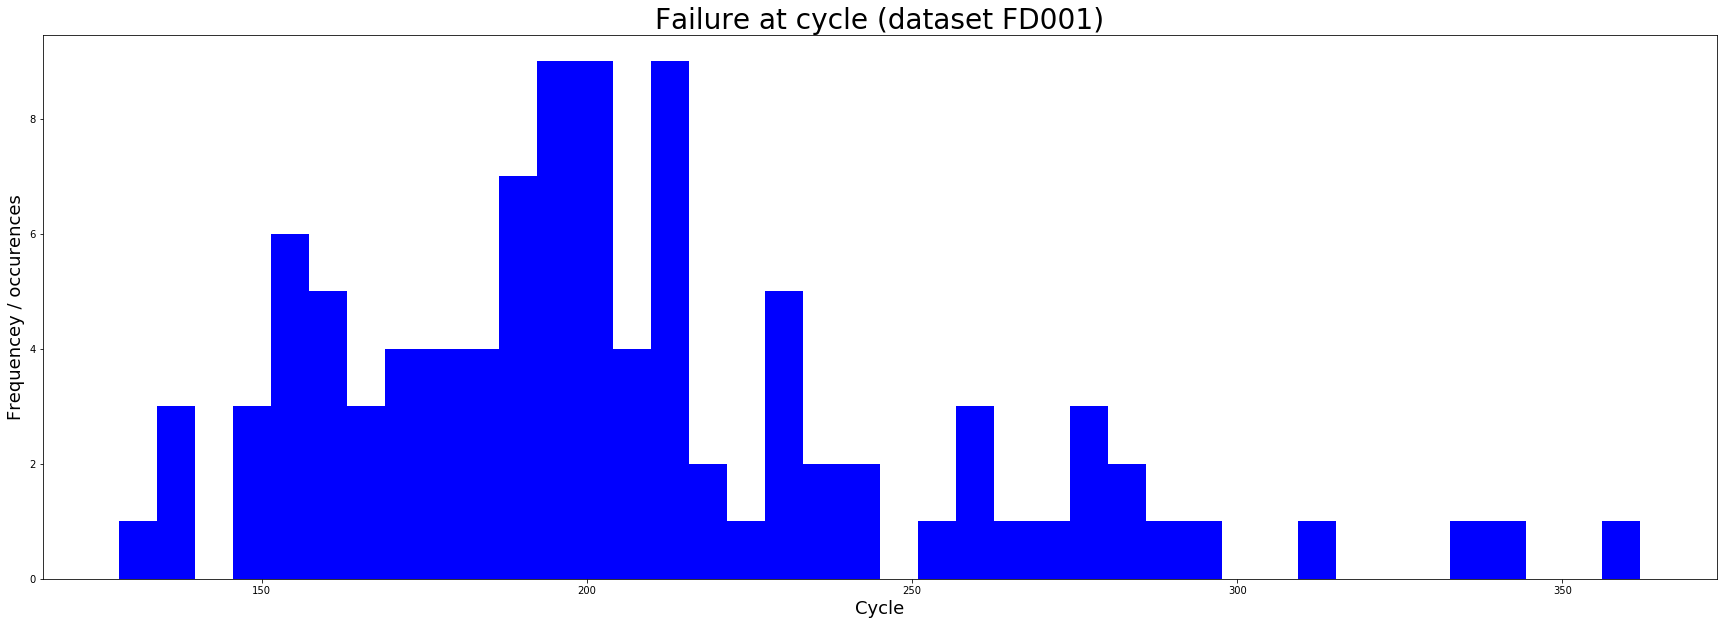

In [11]:
pd_train_fail_cycle_fd001['max'].plot(figsize = (30,10), kind = "hist", color = "blue", bins=40, legend = False)

plt.xlabel("Cycle", fontsize = 18)
plt.ylabel("Frequencey / occurences", fontsize = 18)
plt.title("Failure at cycle (dataset FD001)", fontsize = 28)

plt.show()

So we have had 100 testruns and found a rather large standard deviation. The distribution (histogram doesn't look too good.) Lets enhance the number of buckets.<br>
It does show two main areas, one between 150..250 and one between 250..300. Could this be related to different engine parts failing?<br/>
What happens if we enhance the number of bins?

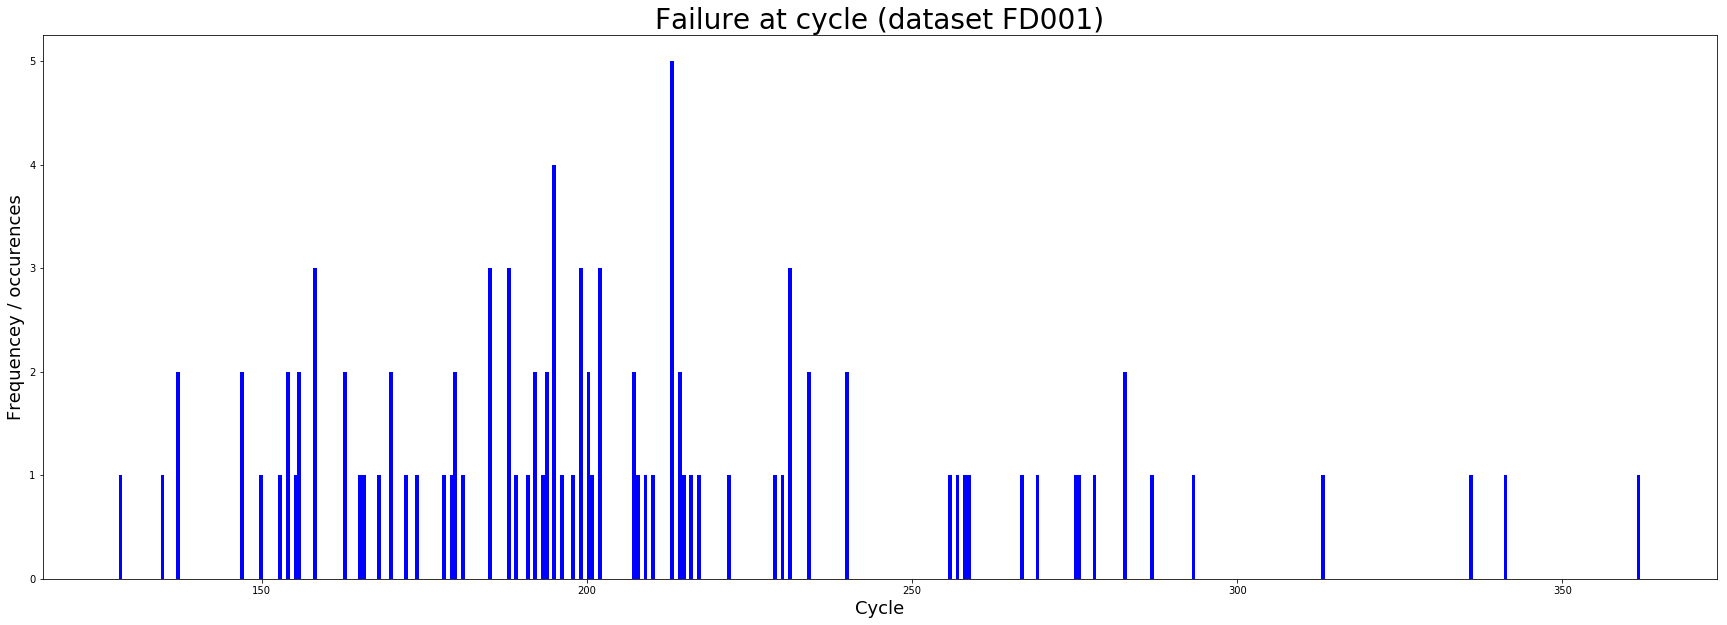

In [12]:
pd_train_fail_cycle_fd001['max'].plot(figsize = (30,10), kind = "hist", color = "blue", bins=400, legend = False)

plt.xlabel("Cycle", fontsize = 18)
plt.ylabel("Frequencey / occurences", fontsize = 18)
plt.title("Failure at cycle (dataset FD001)", fontsize = 28)

plt.show()

Still a pattern, though the second are 250..300 doesn't look as pronunced as in the earlier histogram. <br/>
To be able to verify the prediction later on, we need to add the remaining cycles to the existing data.

In [13]:
pd_train_fd001.head()

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,condition,faultmode,cycleoriginal
0,1,0.00000,0.459770,0.166667,0.0,0.0,0.183730,0.406800,0.309757,0.0,...,0.363989,0.0,0.333333,0.0,0.0,0.713179,0.724662,one,one,1
1,1,0.00277,0.609195,0.250000,0.0,0.0,0.283133,0.453017,0.352634,0.0,...,0.411313,0.0,0.333333,0.0,0.0,0.666667,0.731012,one,one,2
2,1,0.00554,0.252874,0.750000,0.0,0.0,0.343359,0.369522,0.370526,0.0,...,0.357446,0.0,0.166667,0.0,0.0,0.627908,0.621375,one,one,3
3,1,0.00831,0.540230,0.500000,0.0,0.0,0.343359,0.256159,0.331195,0.0,...,0.166605,0.0,0.333333,0.0,0.0,0.573644,0.662385,one,one,4
4,1,0.01108,0.390805,0.333333,0.0,0.0,0.349389,0.257465,0.404625,0.0,...,0.402081,0.0,0.416667,0.0,0.0,0.589149,0.704501,one,one,5


Lets combine the original measurements with the determined failcycle for each unit (engine).

In [14]:
import pandas as pd

merged_train_fd001 = pd.merge(pd_train_fd001, pd_train_fail_cycle_fd001, how='inner', on=['unit'])
merged_train_fd001.head()

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,sensor17,sensor18,sensor19,sensor20,sensor21,condition,faultmode,cycleoriginal,max,total_failed
0,1,0.00000,0.459770,0.166667,0.0,0.0,0.183730,0.406800,0.309757,0.0,...,0.333333,0.0,0.0,0.713179,0.724662,one,one,1,192,40
1,1,0.00277,0.609195,0.250000,0.0,0.0,0.283133,0.453017,0.352634,0.0,...,0.333333,0.0,0.0,0.666667,0.731012,one,one,2,192,40
2,1,0.00554,0.252874,0.750000,0.0,0.0,0.343359,0.369522,0.370526,0.0,...,0.166667,0.0,0.0,0.627908,0.621375,one,one,3,192,40
3,1,0.00831,0.540230,0.500000,0.0,0.0,0.343359,0.256159,0.331195,0.0,...,0.333333,0.0,0.0,0.573644,0.662385,one,one,4,192,40
4,1,0.01108,0.390805,0.333333,0.0,0.0,0.349389,0.257465,0.404625,0.0,...,0.416667,0.0,0.0,0.589149,0.704501,one,one,5,192,40


Now we can determine the remaining usefull life, i.e. the number of remaining cylces for qualification purposes only. I.e. n this offline data processing step. Later when we monitor running engines we dont know the remaining cycles...

In [15]:
# remaining cycles is the maximum number of cycles for a given engine minus the current cycle number
# don't use normalised data for the cycles, hard to interpret

merged_train_fd001['rul'] = merged_train_fd001['max'] - merged_train_fd001['cycleoriginal']
merged_train_fd001.head()

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,sensor18,sensor19,sensor20,sensor21,condition,faultmode,cycleoriginal,max,total_failed,rul
0,1,0.00000,0.459770,0.166667,0.0,0.0,0.183730,0.406800,0.309757,0.0,...,0.0,0.0,0.713179,0.724662,one,one,1,192,40,191
1,1,0.00277,0.609195,0.250000,0.0,0.0,0.283133,0.453017,0.352634,0.0,...,0.0,0.0,0.666667,0.731012,one,one,2,192,40,190
2,1,0.00554,0.252874,0.750000,0.0,0.0,0.343359,0.369522,0.370526,0.0,...,0.0,0.0,0.627908,0.621375,one,one,3,192,40,189
3,1,0.00831,0.540230,0.500000,0.0,0.0,0.343359,0.256159,0.331195,0.0,...,0.0,0.0,0.573644,0.662385,one,one,4,192,40,188
4,1,0.01108,0.390805,0.333333,0.0,0.0,0.349389,0.257465,0.404625,0.0,...,0.0,0.0,0.589149,0.704501,one,one,5,192,40,187


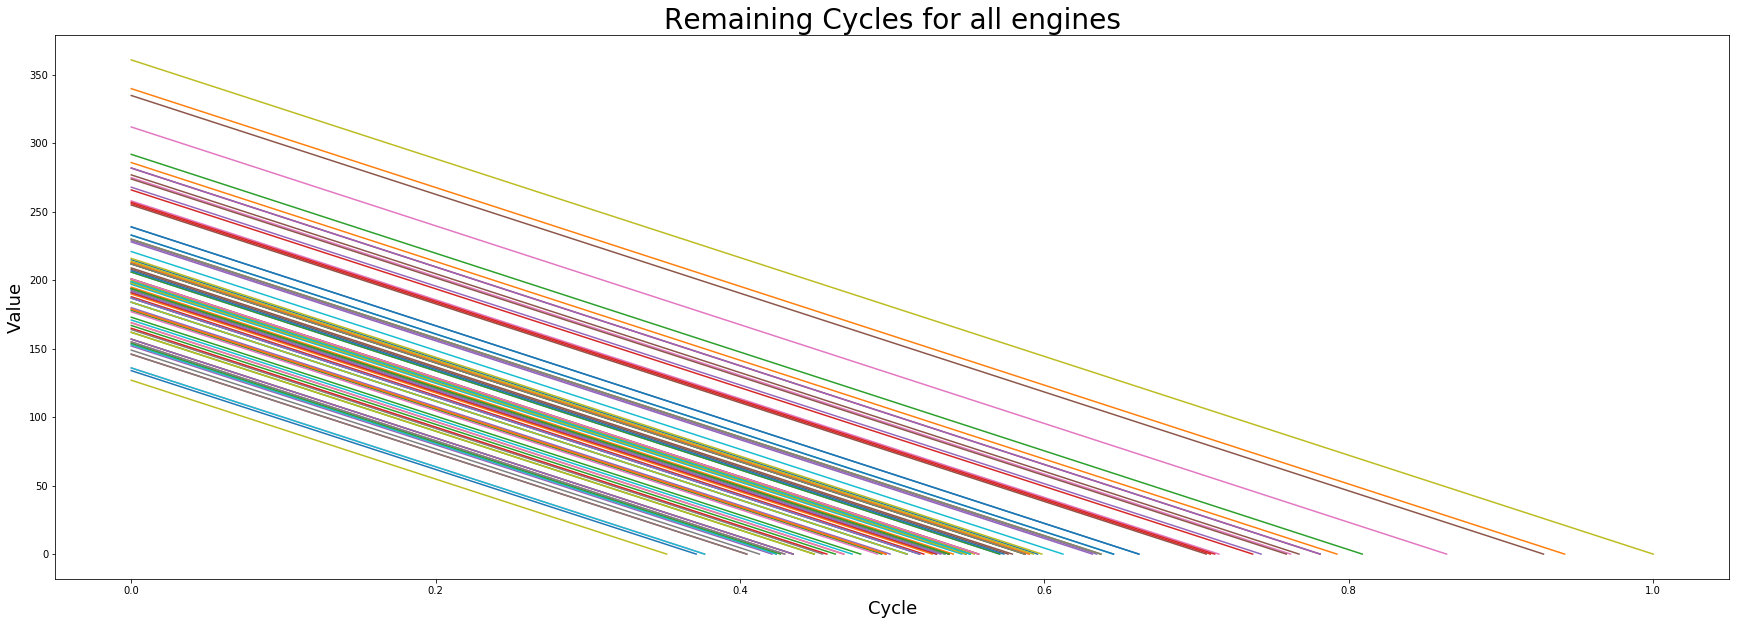

In [16]:
# just for basic check, how do all the engines remaining cycles look, shouldbe straight downsloping lines.
fig, ax = plt.subplots()

for cycle, sensor in merged_train_fd001.groupby(['unit']):
    ax = sensor.plot(figsize = (30,10), ax=ax, kind='line', x='cycle', y='rul', legend=False)

plt.xlabel("Cycle", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.title("Remaining Cycles for all engines", fontsize = 28)


plt.show()

Some refinement, lets filter the data by averaging the measurements over 10 cycles.<br/>
Later we will test if that impoves our model(s).<br/>


In [17]:
# Todo helper function

# columns to average over
# not: unit cycle, condition, faultmode, cycleoriginal, max, total_failed, rul.
columns = ['opset1', 'opset2', 'opset3', 'sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10', \
           'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21', 'rul']

merged_train_fd001.sort_values(by=['unit','cycle'], ascending=True)

for column in columns:
    #print('avg'+column, column)
    newcolumn = 'avg'+column
    
    # Averaging existing column and place data in a new column
    # we are performing the operation mean() function finds the mean over each window 
    merged_train_fd001[newcolumn]= merged_train_fd001[column].rolling(10).mean() 

In [18]:
merged_train_fd001.sort_values(by=['unit','cycle'], ascending=True)
merged_train_fd001[7:14]

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,avgsensor13,avgsensor14,avgsensor15,avgsensor16,avgsensor17,avgsensor18,avgsensor19,avgsensor20,avgsensor21,avgrul
7,1,0.019391,0.304598,0.750000,0.0,0.0,0.406618,0.259863,0.316002,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,0.022161,0.545977,0.583333,0.0,0.0,0.274088,0.434706,0.211851,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,0.024931,0.310345,0.583333,0.0,0.0,0.150602,0.440374,0.307393,0.0,...,0.241350,0.166622,0.321241,0.0,0.316667,0.0,0.0,0.654264,0.684065,186.5
10,1,0.027701,0.603448,0.250000,0.0,0.0,0.322291,0.233485,0.310432,0.0,...,0.239878,0.167634,0.326820,0.0,0.316667,0.0,0.0,0.644961,0.692308,185.5
11,1,0.030471,0.591954,0.666667,0.0,0.0,0.256016,0.269675,0.302161,0.0,...,0.232520,0.169058,0.312199,0.0,0.308333,0.0,0.0,0.649613,0.684355,184.5
12,1,0.033241,0.390805,0.833333,0.0,0.0,0.560235,0.243076,0.313639,0.0,...,0.239878,0.166411,0.311198,0.0,0.333333,0.0,0.0,0.648062,0.674896,183.5
13,1,0.036011,0.551724,0.500000,0.0,0.0,0.343359,0.477652,0.285450,0.0,...,0.228105,0.166720,0.322049,0.0,0.341667,0.0,0.0,0.671318,0.676098,182.5


In [19]:
# Store enriched dataset
store = HDFStore('pd_train_enriched_rul_fd001.h5', mode='w')
store['pd'] = merged_train_fd001
store.close()

Now we have enriched data, does this help when looking at the most important factors.

What if we use the remaining cycles to base another variable on? Earlier i used sensor02, lets use that one again.

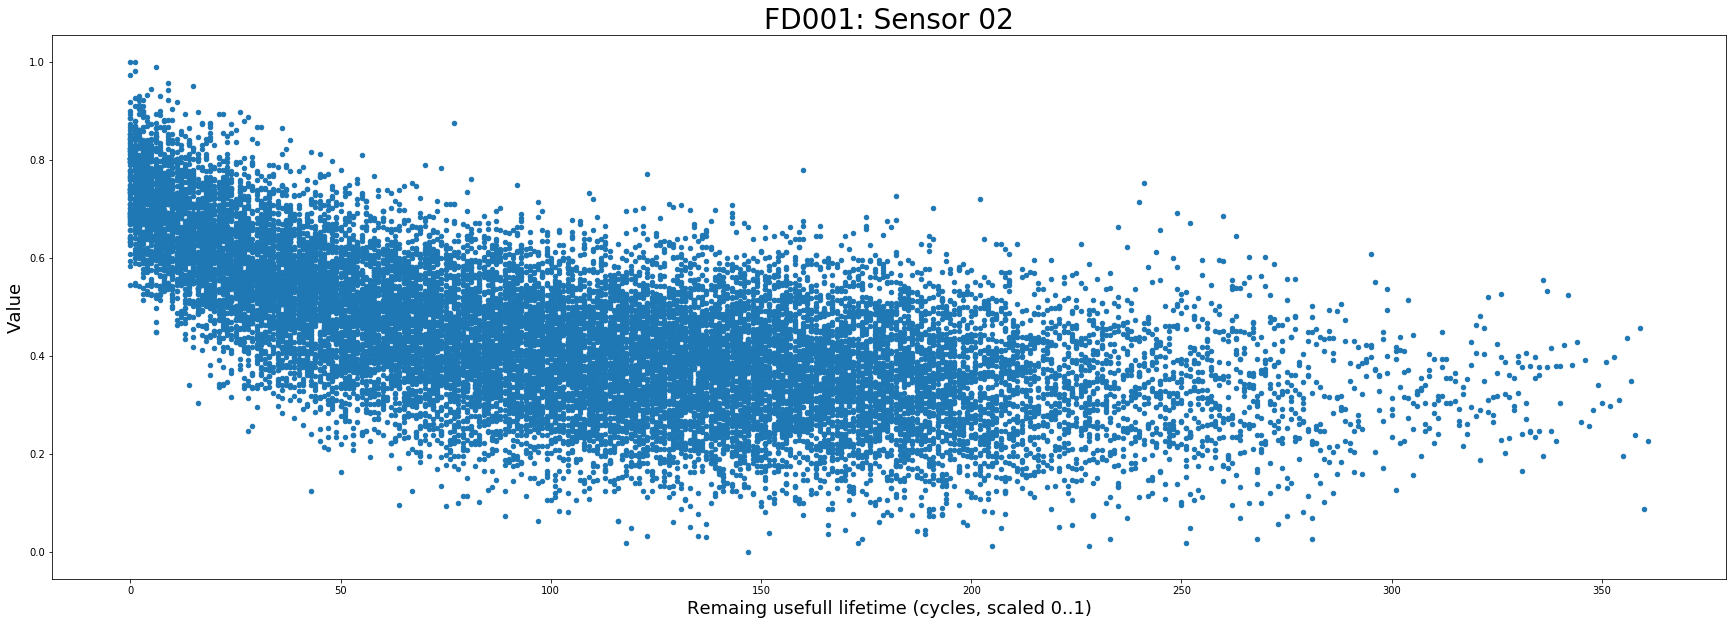

In [20]:
fig, ax = plt.subplots()

for cycle, sensor in merged_train_fd001.groupby(['unit']):
    ax = sensor.plot(figsize = (30,10), ax=ax, kind='scatter', x='rul', y='sensor02', legend=False)

plt.xlabel("Remaing usefull lifetime (cycles, scaled 0..1)", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.title("FD001: Sensor 02", fontsize = 28)

plt.show()

Again an pattern emerges giving confindence we should be able to use the data.

# Quick peek at the other testsets

So we have enriched the data with the remaing life time (in cycles) so we now know the goal for our model. <br>
Let's repeat thos steps for the other datasets. Just curious to see of the conditions of the testruns really make much difference.

Just for a first impression we will have a short look a the moment of failure of an enine in the other datasets.

In [21]:
# set 2, TODO use helpers methods
store = HDFStore('pd_train_fd002_scaled.h5', mode='r')
pd_train_fd002 = store['pd']
store.close()

# find end of life of enines
pd_train_fail_cycle_fd002 = pd_train_fd002.groupby(['unit'], sort=False)['unit','cycleoriginal'].max()
pd_train_fail_cycle_fd002.rename(columns={"cycleoriginal": "max"}, inplace=True)

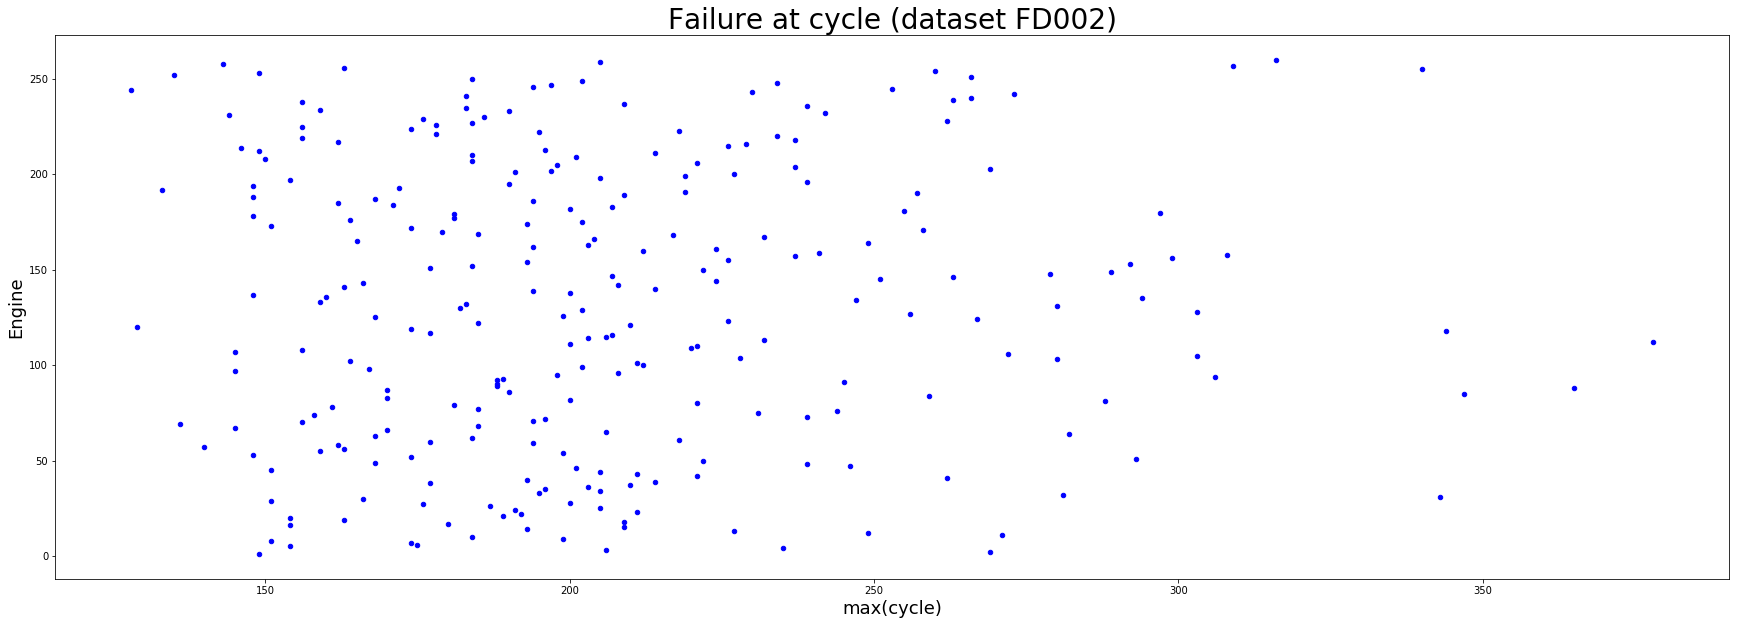

In [22]:
pd_train_fail_cycle_fd002.plot(figsize = (30,10), kind = "scatter", color = "blue", y = "unit", x = "max", legend = False)

plt.ylabel("Engine", fontsize = 18)
plt.xlabel("max(cycle)", fontsize = 18)
plt.title("Failure at cycle (dataset FD002)", fontsize = 28)

plt.show()

For the second test run the failure of an engine seems as much distributed as for the first testset. Only the number of engines is larger which gives a bit of a different impression.

In [23]:
engines = 0

# add total number of failed...
pd_train_fail_cycle_fd002['total_failed'] = 0

for row in pd_train_fail_cycle_fd002.sort_values(by=['max']).itertuples():
    engines += 1
    pd_train_fail_cycle_fd002.at[row.Index, 'total_failed'] = engines
    
pd_train_fail_cycle_fd002.sort_values(by=['max']).head()

,unit,max,total_failed
unit,,,
244,244,128,1
120,120,129,2
192,192,133,3
252,252,135,4
69,69,136,5


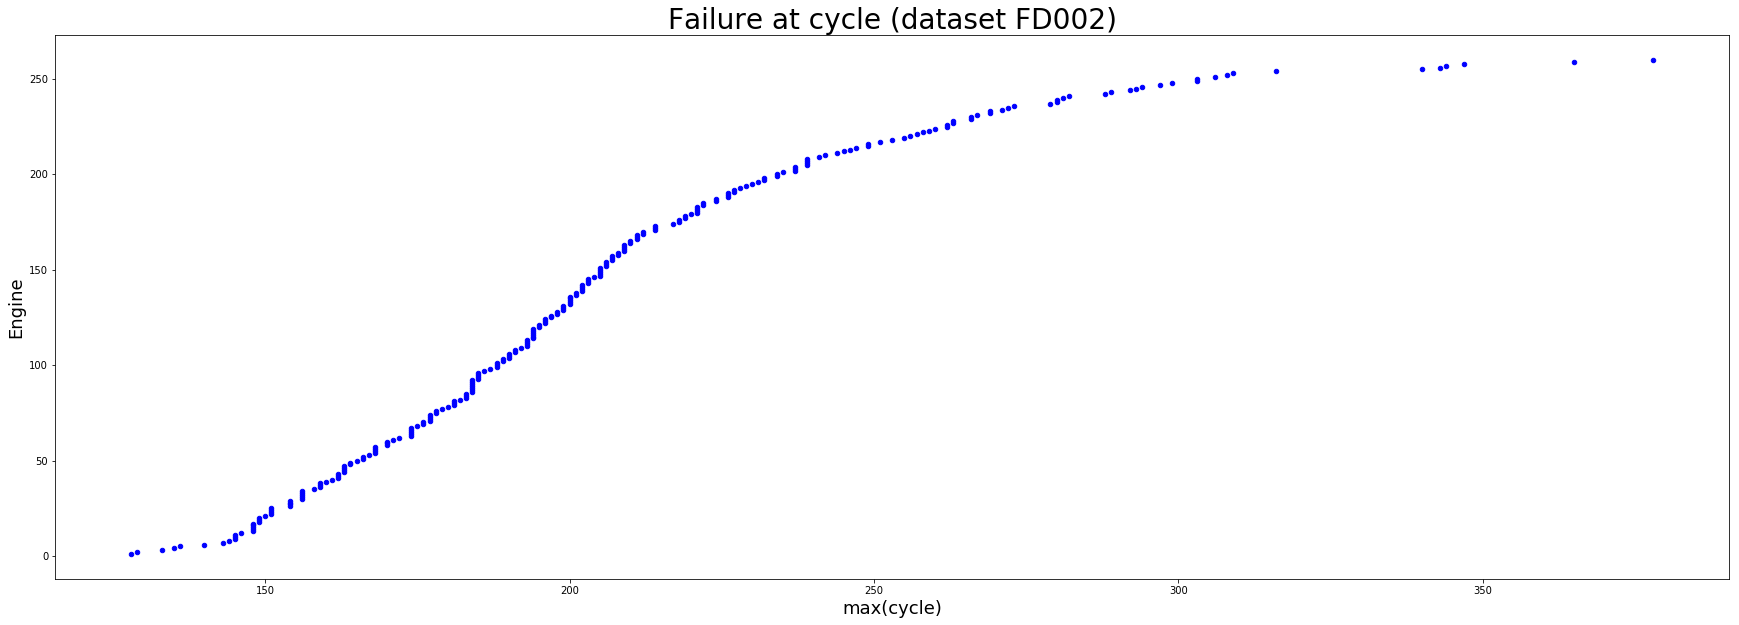

In [24]:
pd_train_fail_cycle_fd002.plot(figsize = (30,10), kind = "scatter", color = "blue", y = "total_failed", x = "max", legend = False)

plt.ylabel("Engine", fontsize = 18)
plt.xlabel("max(cycle)", fontsize = 18)
plt.title("Failure at cycle (dataset FD002)", fontsize = 28)

plt.show()

Compared to the first testset, this curve doens't look that much different. just a bit smoother since we have tested more engines.

In [25]:
pd_train_fail_cycle_fd002['max'].describe()

count    260.000000
mean     206.765385
std       46.782198
min      128.000000
25%      174.000000
50%      199.000000
75%      230.250000
max      378.000000
Name: max, dtype: float64

Oddly enough, the stats are close the the stats for testrun 1, for example the mean and the standard devitation. It seems that the test conditions have not muchh influence...

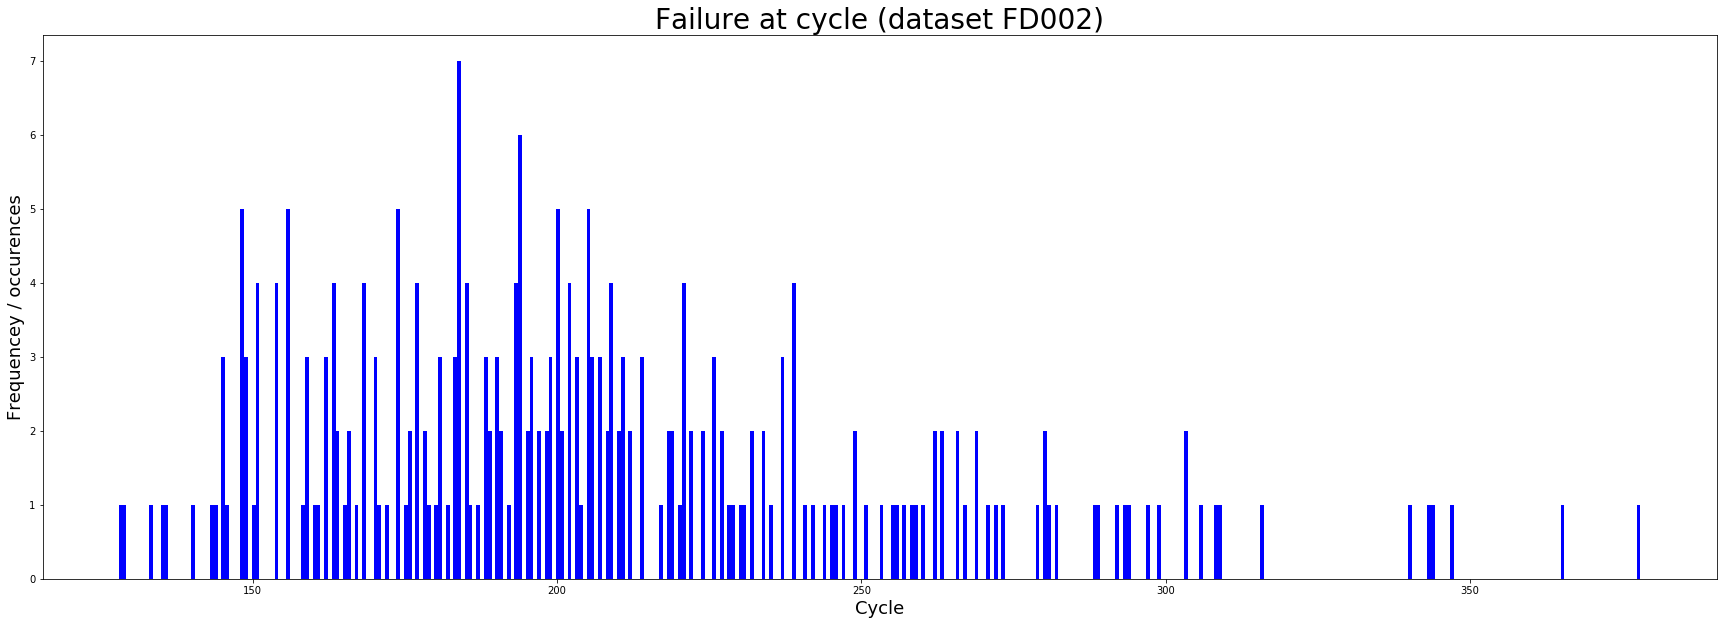

In [26]:
pd_train_fail_cycle_fd002['max'].plot(figsize = (30,10), kind = "hist", color = "blue", bins=400, legend = False)

plt.xlabel("Cycle", fontsize = 18)
plt.ylabel("Frequencey / occurences", fontsize = 18)
plt.title("Failure at cycle (dataset FD002)", fontsize = 28)

plt.show()

Compared the datset 1 there the bulk of the eniges seem to fail between 250..250 and less after that.

In [27]:
merged_train_fd002        = pd.merge(pd_train_fd002, pd_train_fail_cycle_fd002, how='inner', on=['unit'])
merged_train_fd002['rul'] = merged_train_fd002['max'] - merged_train_fd002['cycleoriginal']
merged_train_fd002.head()

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,sensor18,sensor19,sensor20,sensor21,condition,faultmode,cycleoriginal,max,total_failed,rul
0,1,0.000000,0.833134,0.997625,1.0,0.060269,0.181576,0.311201,0.273095,0.146592,...,0.651163,1.0,0.156036,0.159082,six,one,1,149,19,148
1,1,0.002653,0.999767,0.998575,1.0,0.000000,0.131847,0.296600,0.245535,0.000000,...,0.627907,1.0,0.007888,0.014562,six,one,2,149,19,147
2,1,0.005305,0.595096,0.738480,0.0,0.238089,0.016331,0.035297,0.056997,0.293184,...,0.000000,0.0,0.133745,0.151414,six,one,3,149,19,146
3,1,0.007958,0.999993,0.999525,1.0,0.000000,0.128268,0.298795,0.246979,0.000000,...,0.627907,1.0,0.014060,0.026144,six,one,4,149,19,145
4,1,0.010610,0.595137,0.736698,0.0,0.238089,0.014130,0.037871,0.058152,0.293184,...,0.000000,0.0,0.135460,0.143240,six,one,5,149,19,144


In [28]:
# Todo helper function
# columns to average over
# not: unit cycle, condition, faultmode, cycleoriginal, max, total_failed, rul.
columns = ['opset1', 'opset2', 'opset3', 'sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10', \
           'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21', 'rul']

merged_train_fd002.sort_values(by=['unit','cycle'], ascending=True)

for column in columns:
    #print('avg'+column, column)
    newcolumn = 'avg'+column
    
    # Averaging existing column and place data in a new column
    # we are performing the operation mean() function finds the mean over each window 
    merged_train_fd002[newcolumn]= merged_train_fd002[column].rolling(10).mean() 

In [29]:
# Store enriched dataset
store = HDFStore('pd_train_enriched_rul_fd002.h5', mode='w')
store['pd'] = merged_train_fd002
store.close()

Quick look at test set #3

In [30]:
# set 3, TODO use helpers methods
store = HDFStore('pd_train_fd003_scaled.h5', mode='r')
pd_train_fd003 = store['pd']
store.close()

# find end of life of enines
pd_train_fail_cycle_fd003 = pd_train_fd003.groupby(['unit'], sort=False)['unit','cycleoriginal'].max()
pd_train_fail_cycle_fd003.rename(columns={"cycleoriginal": "max"}, inplace=True)

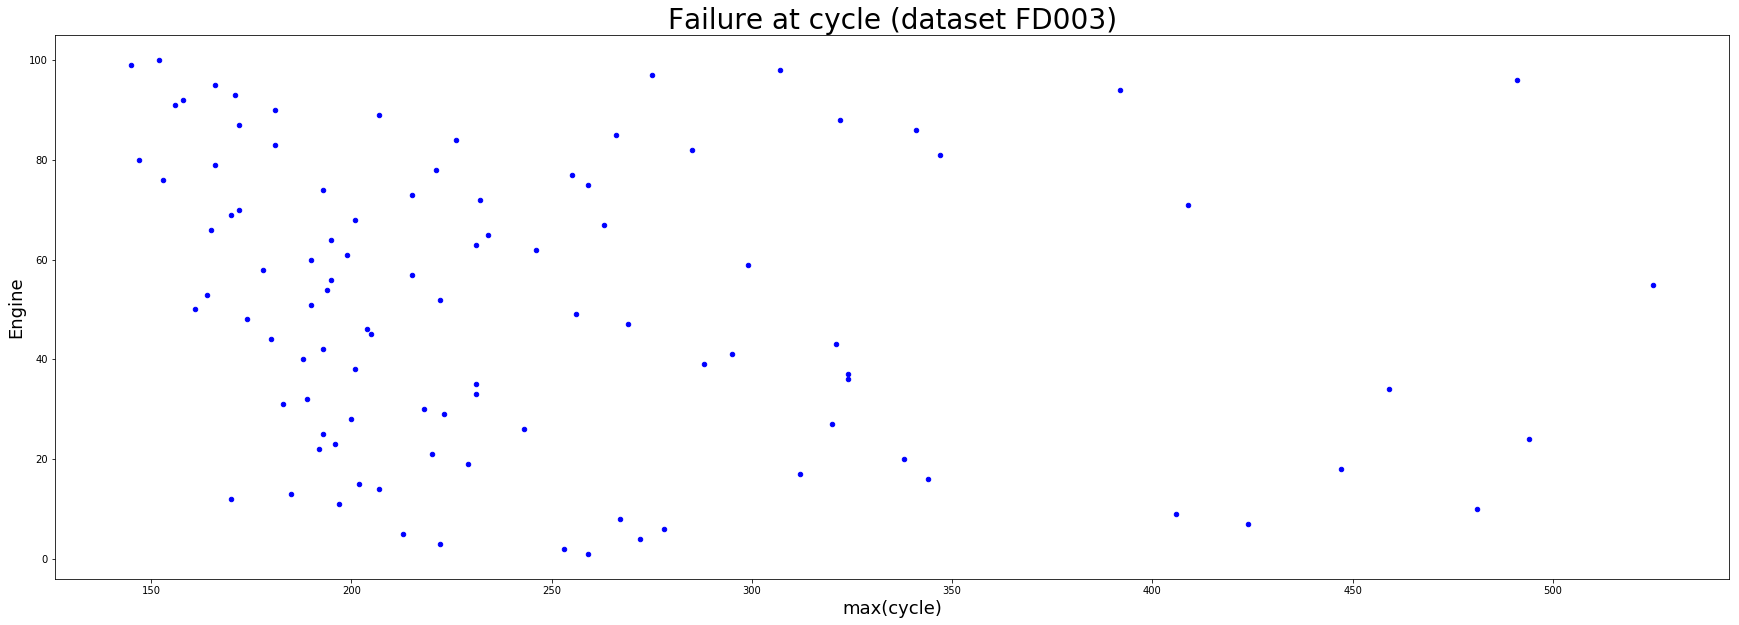

In [31]:
pd_train_fail_cycle_fd003.plot(figsize = (30,10), kind = "scatter", color = "blue", y = "unit", x = "max", legend = False)

plt.ylabel("Engine", fontsize = 18)
plt.xlabel("max(cycle)", fontsize = 18)
plt.title("Failure at cycle (dataset FD003)", fontsize = 28)

plt.show()

Again the plot looks much the same as for the first test run.

In [32]:
engines = 0

# add total number of failed...
pd_train_fail_cycle_fd003['total_failed'] = 0

for row in pd_train_fail_cycle_fd003.sort_values(by=['max']).itertuples():
    engines += 1
    pd_train_fail_cycle_fd003.at[row.Index, 'total_failed'] = engines
    
pd_train_fail_cycle_fd003.sort_values(by=['max']).head()

,unit,max,total_failed
unit,,,
99,99,145,1
80,80,147,2
100,100,152,3
76,76,153,4
91,91,156,5


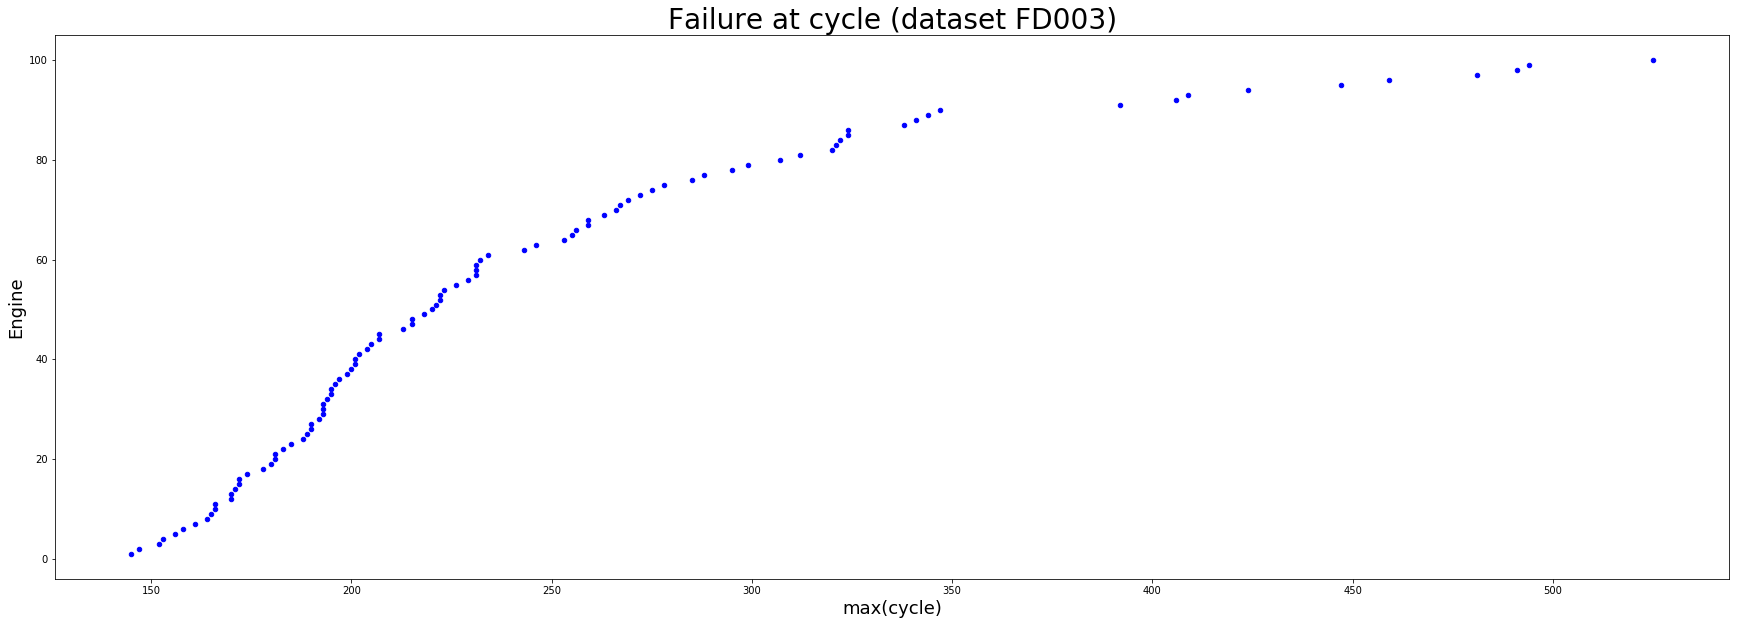

In [33]:
pd_train_fail_cycle_fd003.plot(figsize = (30,10), kind = "scatter", color = "blue", y = "total_failed", x = "max", legend = False)

plt.ylabel("Engine", fontsize = 18)
plt.xlabel("max(cycle)", fontsize = 18)
plt.title("Failure at cycle (dataset FD003)", fontsize = 28)

plt.show()

The curve looks much the same as for the first test run.

In [34]:
pd_train_fail_cycle_fd003['max'].describe()

count    100.00000
mean     247.20000
std       86.48384
min      145.00000
25%      189.75000
50%      220.50000
75%      279.75000
max      525.00000
Name: max, dtype: float64

Now the mean 247 is clearly different compared to test run 1 and 2 where it was about 206. Note that the standard deviation is about twice the size of the first and second test run. So it would be harder to predict the right moment of failure.

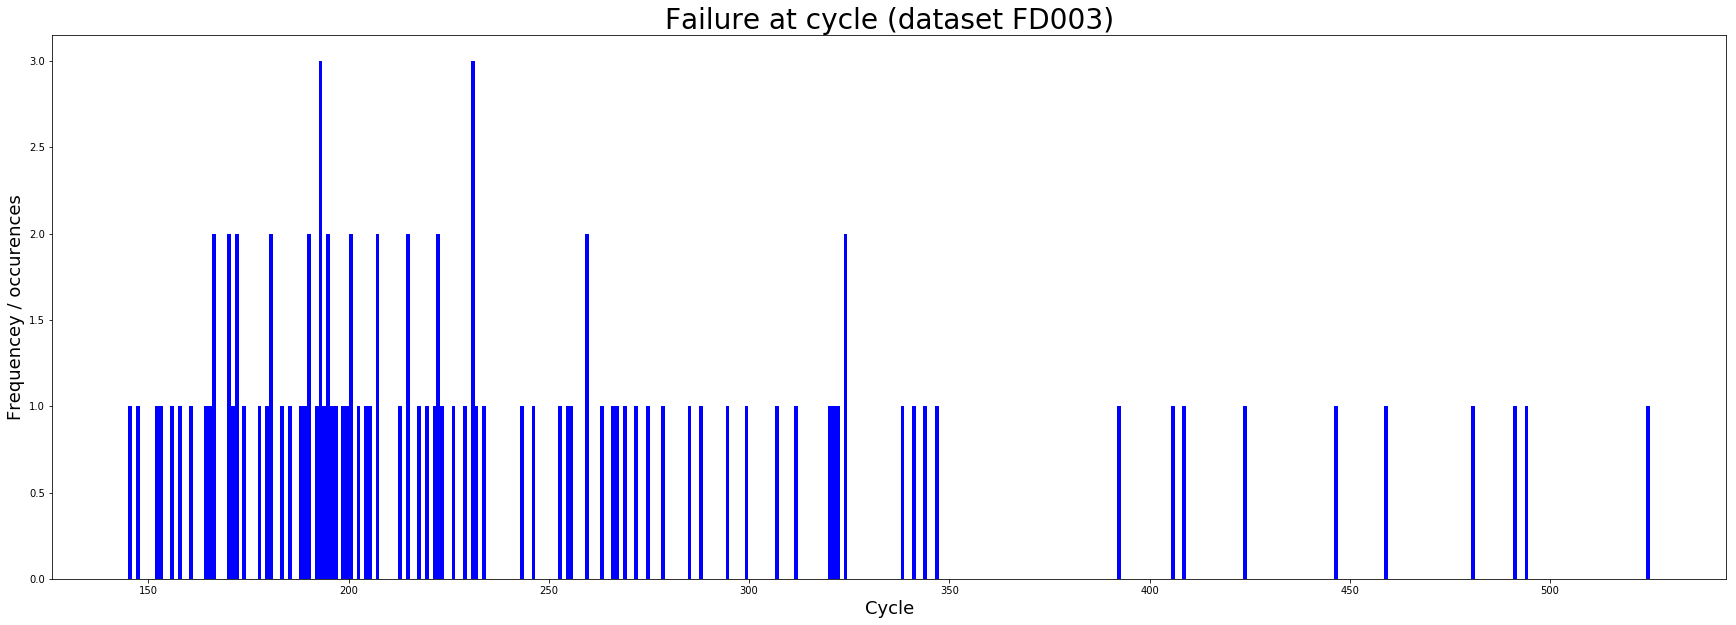

In [35]:
pd_train_fail_cycle_fd003['max'].plot(figsize = (30,10), kind = "hist", color = "blue", bins=400, legend = False)

plt.xlabel("Cycle", fontsize = 18)
plt.ylabel("Frequencey / occurences", fontsize = 18)
plt.title("Failure at cycle (dataset FD003)", fontsize = 28)

plt.show()

This dataset seems to have a less clear / distinct moment of failure, looks more evenly distributed.

In [36]:
merged_train_fd003        = pd.merge(pd_train_fd003, pd_train_fail_cycle_fd003, how='inner', on=['unit'])
merged_train_fd003['rul'] = merged_train_fd003['max'] - merged_train_fd003['cycle']
merged_train_fd003.head()

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,sensor18,sensor19,sensor20,sensor21,condition,faultmode,cycleoriginal,max,total_failed,rul
0,1,0.000000,0.470930,0.769231,0.0,0.0,0.355966,0.370522,0.308579,0.0,...,0.0,0.0,0.559525,0.446331,one,two,1,259,68,259.000000
1,1,0.001908,0.546512,0.230769,0.0,0.0,0.388756,0.399098,0.309360,0.0,...,0.0,0.0,0.488097,0.534836,one,two,2,259,68,258.998092
2,1,0.003817,0.418605,0.307692,0.0,0.0,0.313812,0.353297,0.445397,0.0,...,0.0,0.0,0.404762,0.458576,one,two,3,259,68,258.996183
3,1,0.005725,0.383721,0.538462,0.0,0.0,0.487114,0.417106,0.237285,0.0,...,0.0,0.0,0.470239,0.391965,one,two,4,259,68,258.994275
4,1,0.007634,0.593023,0.461538,0.0,0.0,0.196715,0.476218,0.321216,0.0,...,0.0,0.0,0.577382,0.543371,one,two,5,259,68,258.992366


In [37]:
# Tod o helper function
# columns to average over
# not: unit cycle, condition, faultmode, cycleoriginal, max, total_failed, rul.
columns = ['opset1', 'opset2', 'opset3', 'sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10', \
           'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21','rul']

merged_train_fd003.sort_values(by=['unit','cycle'], ascending=True)

for column in columns:
    #print('avg'+column, column)
    newcolumn = 'avg'+column
    
    # Averaging existing column and place data in a new column
    # we are performing the operation mean() function finds the mean over each window 
    merged_train_fd003[newcolumn]= merged_train_fd003[column].rolling(10).mean() 

In [38]:
# Store enriched dataset
store = HDFStore('pd_train_enriched_rul_fd003.h5', mode='w')
store['pd'] = merged_train_fd003
store.close()

In [39]:
# set 4, TODO use helpers methods
store = HDFStore('pd_train_fd004_scaled.h5', mode='r')
pd_train_fd004 = store['pd']
store.close()

# find end of life of enines
pd_train_fail_cycle_fd004 = pd_train_fd004.groupby(['unit'], sort=False)['unit','cycleoriginal'].max()
pd_train_fail_cycle_fd004.rename(columns={"cycleoriginal": "max"}, inplace=True)

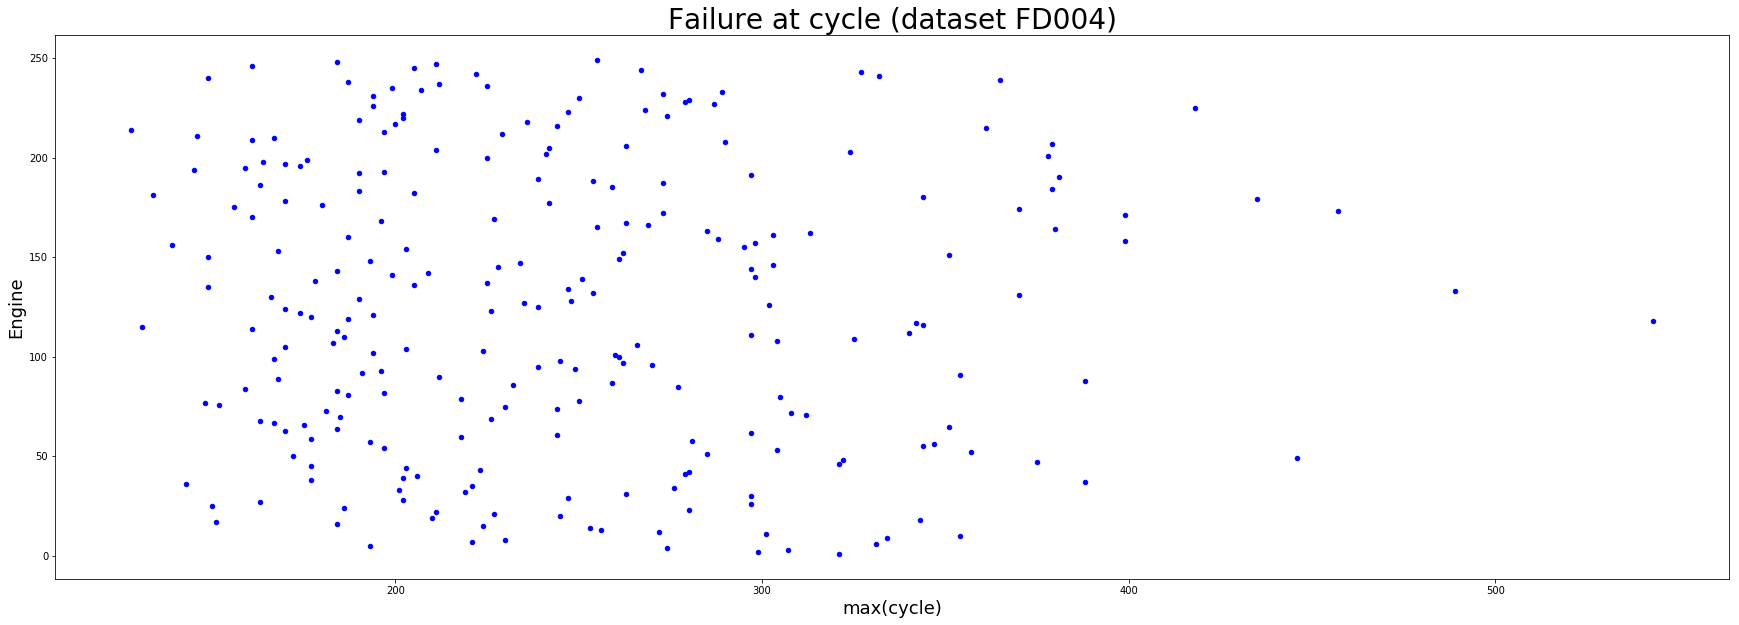

In [40]:
pd_train_fail_cycle_fd004.plot(figsize = (30,10), kind = "scatter", color = "blue", y = "unit", x = "max", legend = False)

plt.ylabel("Engine", fontsize = 18)
plt.xlabel("max(cycle)", fontsize = 18)
plt.title("Failure at cycle (dataset FD004)", fontsize = 28)

plt.show()

Again the plot looks much the same. This gives the impression it should be possible to predict the moemnt of failure for all 4 testruns.

In [41]:
engines = 0

# add total number of failed...
pd_train_fail_cycle_fd004['total_failed'] = 0

for row in pd_train_fail_cycle_fd004.sort_values(by=['max']).itertuples():
    engines += 1
    pd_train_fail_cycle_fd004.at[row.Index, 'total_failed'] = engines
    
pd_train_fail_cycle_fd004.sort_values(by=['max']).head()

,unit,max,total_failed
unit,,,
214,214,128,1
115,115,131,2
181,181,134,3
156,156,139,4
36,36,143,5


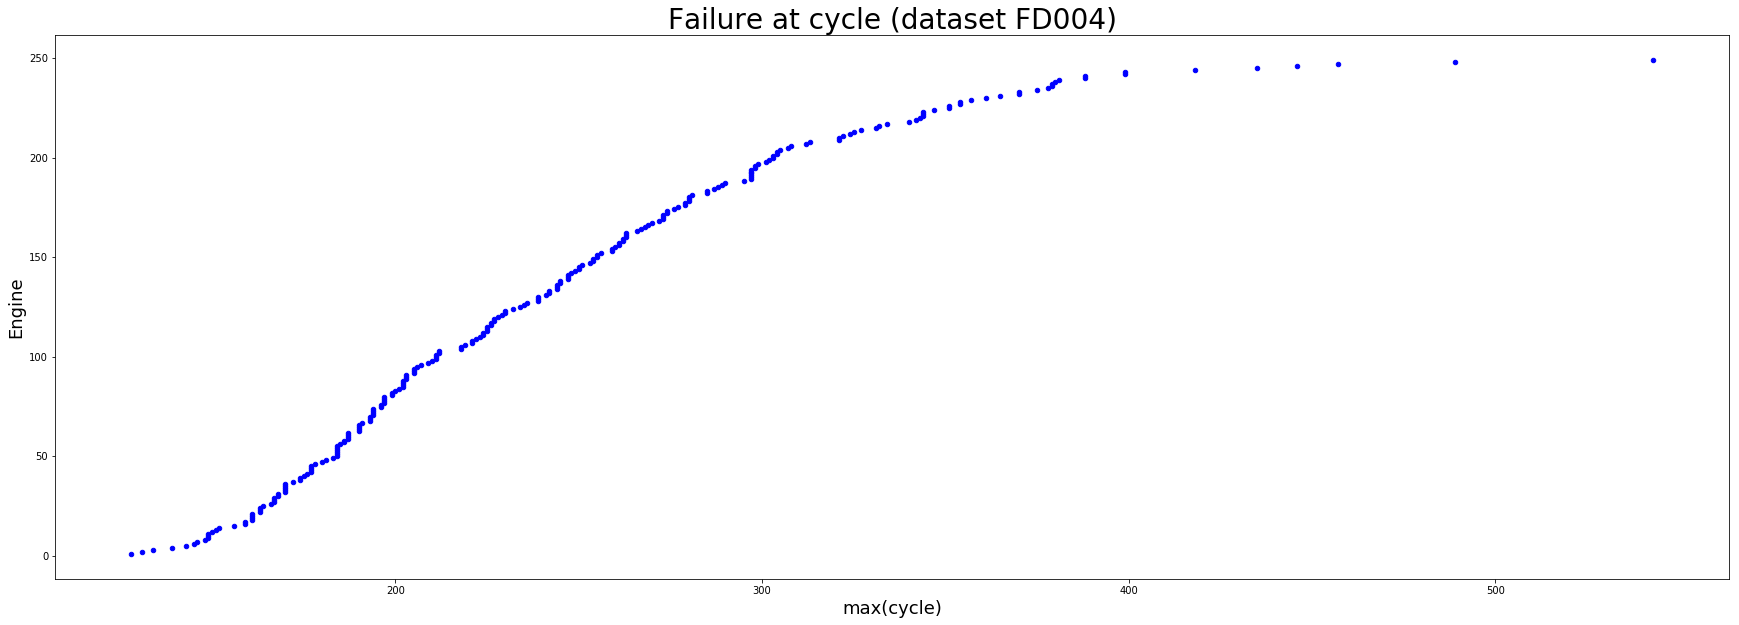

In [42]:
pd_train_fail_cycle_fd004.plot(figsize = (30,10), kind = "scatter", color = "blue", y = "total_failed", x = "max", legend = False)

plt.ylabel("Engine", fontsize = 18)
plt.xlabel("max(cycle)", fontsize = 18)
plt.title("Failure at cycle (dataset FD004)", fontsize = 28)

plt.show()

Again the curve looks much the same. Let try to plot them all together

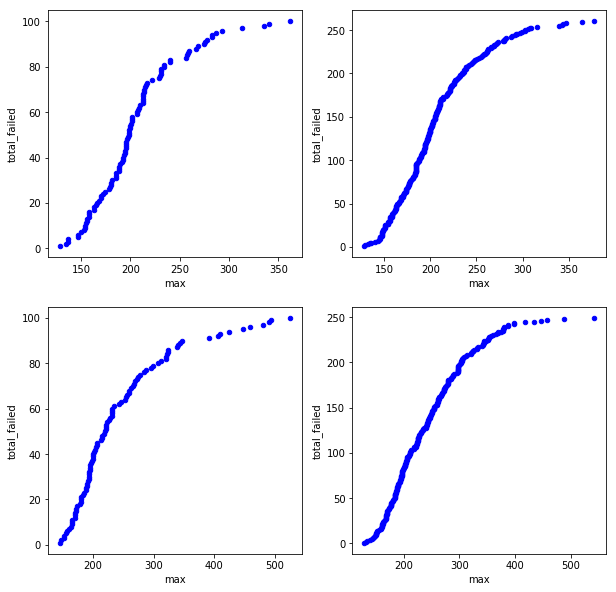

In [43]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2)

pd_train_fail_cycle_fd001.plot(ax=axes[0,0], figsize = (15,15), kind = "scatter", color = "blue", y = "total_failed", x = "max", legend = False)
pd_train_fail_cycle_fd002.plot(ax=axes[0,1], figsize = (10,10), kind = "scatter", color = "blue", y = "total_failed", x = "max", legend = False)
pd_train_fail_cycle_fd003.plot(ax=axes[1,0], figsize = (10,10), kind = "scatter", color = "blue", y = "total_failed", x = "max", legend = False)
pd_train_fail_cycle_fd004.plot(ax=axes[1,1], figsize = (10,10), kind = "scatter", color = "blue", y = "total_failed", x = "max", legend = False)
#plt.ylabel("Engine", fontsize = 18)
#plt.xlabel("max(cycle)", fontsize = 18)
#plt.title("Failure at cycle (dataset FD001)", fontsize = 28)

plt.show()

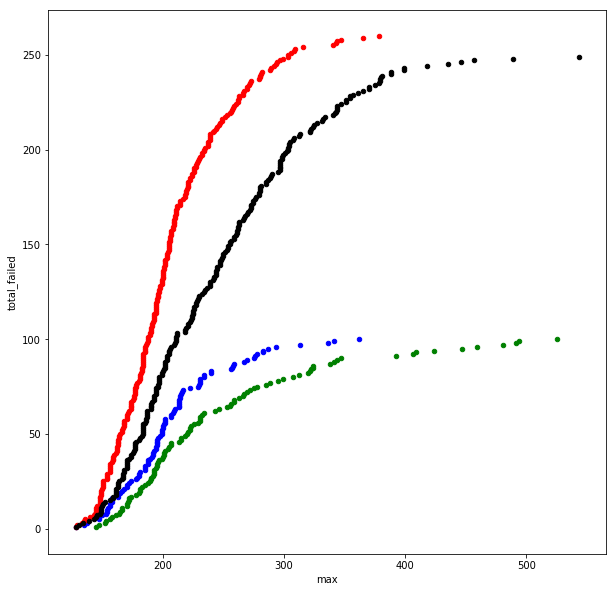

In [44]:
# attemp in overlapping
fig, axes = plt.subplots()

#ax2 = ax.twiny()

pd_train_fail_cycle_fd001.plot(ax=axes, figsize = (15,15), kind = "scatter", color = "blue", y = "total_failed", x = "max", legend = True)
pd_train_fail_cycle_fd002.plot(ax=axes, figsize = (10,10), kind = "scatter", color = "red", y = "total_failed", x = "max", legend = True)
pd_train_fail_cycle_fd003.plot(ax=axes, figsize = (10,10), kind = "scatter", color = "green", y = "total_failed", x = "max", legend = True)
pd_train_fail_cycle_fd004.plot(ax=axes, figsize = (10,10), kind = "scatter", color = "black", y = "total_failed", x = "max", legend = True)
#plt.ylabel("Engine", fontsize = 18)
#plt.xlabel("max(cycle)", fontsize = 18)
#plt.title("Failure at cycle (dataset FD001)", fontsize = 28)

plt.show()

When drawn overlapping the plots look simular and they'e also clearly different.

In [45]:
pd_train_fail_cycle_fd004['max'].describe()

count    249.00000
mean     245.97992
std       73.11080
min      128.00000
25%      190.00000
50%      234.00000
75%      290.00000
max      543.00000
Name: max, dtype: float64

Again, the statistics on the failure are different compared to set 1 and 2.

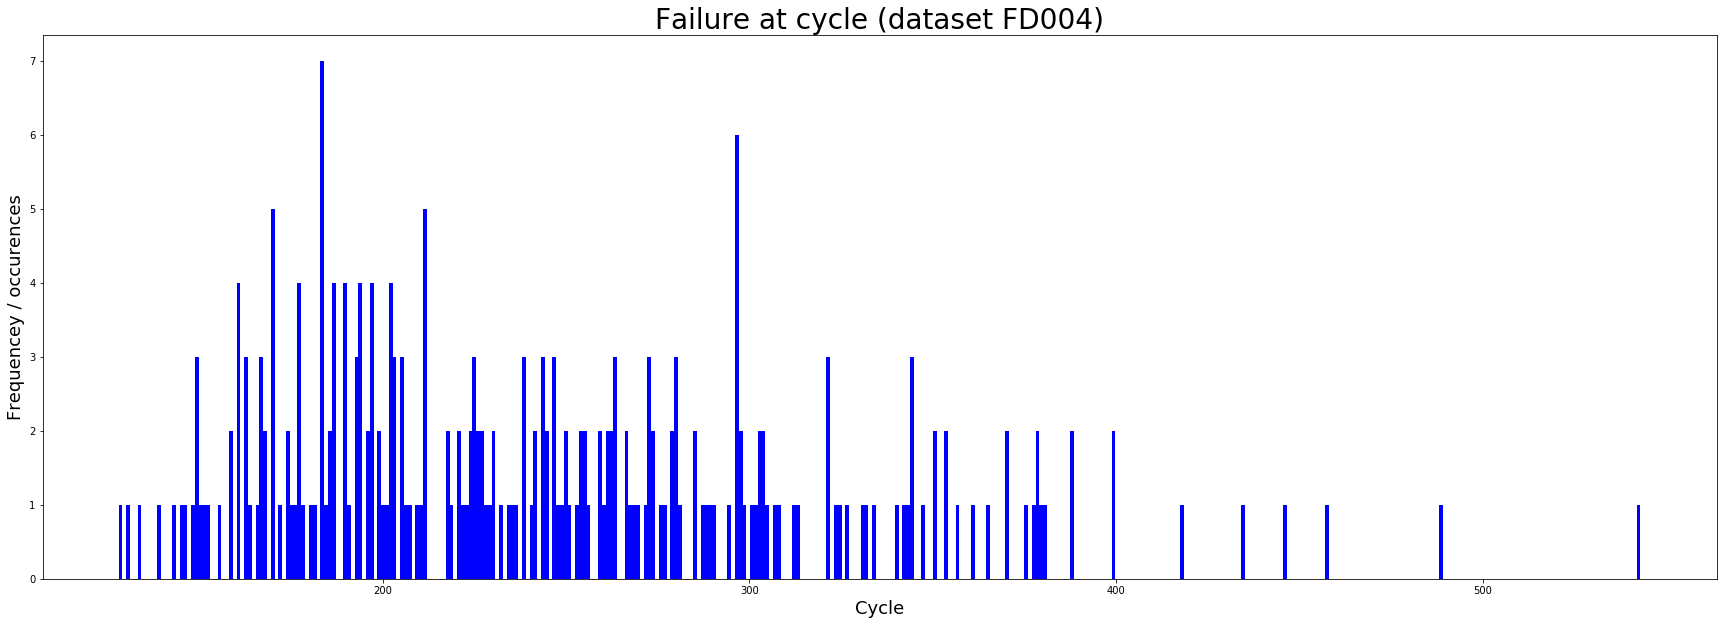

In [46]:
pd_train_fail_cycle_fd004['max'].plot(figsize = (30,10), kind = "hist", color = "blue", bins=400, legend = False)

plt.xlabel("Cycle", fontsize = 18)
plt.ylabel("Frequencey / occurences", fontsize = 18)
plt.title("Failure at cycle (dataset FD004)", fontsize = 28)

plt.show()

In [47]:
merged_train_fd004        = pd.merge(pd_train_fd004, pd_train_fail_cycle_fd004, how='inner', on=['unit'])
merged_train_fd004['rul'] = merged_train_fd004['max'] - merged_train_fd004['cycle']
merged_train_fd004.head()

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,sensor18,sensor19,sensor20,sensor21,condition,faultmode,cycleoriginal,max,total_failed,rul
0,1,0.000000,0.999926,0.997625,1.0,0.000000,0.130347,0.272082,0.212586,0.000000,...,0.627907,1.0,0.015473,0.015881,six,two,1,321,210,321.000000
1,1,0.001845,0.476147,0.831591,1.0,0.626985,0.647972,0.634407,0.511781,0.507937,...,0.864693,1.0,0.477968,0.481487,six,two,2,321,210,320.998155
2,1,0.003690,0.999900,0.998694,1.0,0.000000,0.123646,0.271244,0.222481,0.000000,...,0.627907,1.0,0.010764,0.018932,six,two,3,321,210,320.996310
3,1,0.005535,0.999810,0.997625,1.0,0.000000,0.121351,0.266168,0.224835,0.000000,...,0.627907,1.0,0.012782,0.018724,six,two,4,321,210,320.994465
4,1,0.007380,0.595275,0.737173,0.0,0.238089,0.005691,0.033916,0.022025,0.293184,...,0.000000,0.0,0.130172,0.145560,six,two,5,321,210,320.992620


In [48]:
# Store enriched dataset
store = HDFStore('pd_train_enriched_rul_fd004.h5', mode='w')
store['pd'] = merged_train_fd004
store.close()

# Comparing the 4 runs with respect to moment of failure

Compare the failure cycle stats if the 4 test runs.

In [49]:
pd_train_fail_cycle_fd004.head()

,unit,max,total_failed
unit,,,
1,1,321,210
2,2,299,197
3,3,307,205
4,4,274,172
5,5,193,70


In [50]:
# to merge nicely, rename columns
pd_train_fail_cycle_fd001.rename(columns={"max": "max_FD001", "total_failed":"total_failed_FD001"}, inplace=True)
pd_train_fail_cycle_fd002.rename(columns={"max": "max_FD002", "total_failed":"total_failed_FD002"}, inplace=True)
pd_train_fail_cycle_fd003.rename(columns={"max": "max_FD003", "total_failed":"total_failed_FD003"}, inplace=True)
pd_train_fail_cycle_fd004.rename(columns={"max": "max_FD004", "total_failed":"total_failed_FD004"}, inplace=True)

pd_train_fail_cycles = pd.merge(pd_train_fail_cycle_fd001.describe(), pd_train_fail_cycle_fd002.describe(), left_index=True, right_index=True)
pd_train_fail_cycles = pd.merge(pd_train_fail_cycles, pd_train_fail_cycle_fd003.describe(), left_index=True, right_index=True)
pd_train_fail_cycles = pd.merge(pd_train_fail_cycles, pd_train_fail_cycle_fd004.describe(), left_index=True, right_index=True)

In [51]:
#pd_train_fail_cycles = pd_train_fail_cycles.drop(columns=['unit_x', 'unit_y'])

pd_train_fail_cycles[['max_FD001','max_FD002','max_FD003','max_FD004']].head()

,max_FD001,max_FD002,max_FD003,max_FD004
count,100.000000,260.000000,100.00000,249.00000
mean,206.310000,206.765385,247.20000,245.97992
std,46.342749,46.782198,86.48384,73.11080
min,128.000000,128.000000,145.00000,128.00000
25%,177.000000,174.000000,189.75000,190.00000


Funny enough despite the amount of failcycles in the data sets they are quite simular, looking at the failcycle data.
For example, the mean about 0.569 or 0.47 seem to point to a specific type of error of the engine.<br/>

Recall the dataset description:<br/>

| Data Set  | Train trajectories   | Test trajectories   | Conditions      | Fault Modes                             |
| --------- |:-------------------- |:------------------- | ---------------:|:--------------------------------------  |
| FD001     | 100                  | 100                 | ONE (Sea Level) | ONE (HPC Degradation)                   |
| FD002     | 260                  | 259                 | SIX             | ONE (HPC Degradation)                   |
| FD003     | 100                  | 100                 | ONE (Sea Level) | TWO (HPC Degradation, Fan Degradation)  |
| FD004     | 248                  | 249                 | SIX             | TWO (HPC Degradation, Fan Degradation)  |

<br/>


### Failures and remaining cycles

Just by looking at the plots of the data it's hard to tell much about the remaining cycles for an engine. Can a model actually retrieve some information out of this?